
**Importing Libraries**

In [ ]:
import os

import warnings

from IPython.display import HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import seaborn as sns
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, default_collate, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from PIL import Image, ImageFile

from tqdm.auto import tqdm

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
color_list = ['#faa5c7', '#eb679c', '#cc3d76', '#b3245d', '#d40457', '#8f1042', '#6e042e']
color_palette = sns.color_palette(color_list)
sns.set_palette(color_palette)

# cmap = colors.ListedColormap(color_palette)
cmap = LinearSegmentedColormap.from_list('custom_palette', color_list, N=256)

warnings.filterwarnings("ignore")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Dataset**

In [ ]:
input_directory = '/content/drive/MyDrive/archive (1)/Bone_Fracture_Binary_Classification'
output_directory = '/content/drive/MyDrive/archive (1)/working'
dataset_directory = f'{output_directory}/dataset'
output_train_directory = f'{dataset_directory}/Bone_Fracture_Binary_Classification/train'
output_dev_directory = f'{dataset_directory}/Bone_Fracture_Binary_Classification/val'
output_test_directory = f'{dataset_directory}/Bone_Fracture_Binary_Classification/test'

In [ ]:
def removeCorruptFiles(directory_path):
  for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)

    if os.path.isdir(item_path):
      removeCorruptFiles(item_path)
    else:
      try:
        Image.open(item_path).verify()
      except (IOError, SyntaxError):
        os.remove(item_path)
        print(f'Removed corrupted image: {item}')

In [ ]:
def removeEmptySubdirectories(directory):
    # Iterate over each entry in the directory
    for entry in os.listdir(directory):
        # Create full path
        full_path = os.path.join(directory, entry)

        # If entry is a directory, recursively remove empty subdirectories
        if os.path.isdir(full_path):
            removeEmptySubdirectories(full_path)

            # Check if directory is empty after removal
            if not os.listdir(full_path):
                # Remove the directory if it's empty
                os.rmdir(full_path)
                print(f"Removed empty directory: {full_path}")

In [ ]:
def copyDatasetIntoWorkingDir(source_directory, destination_directory):
    # Remove the destination directory if it already exists
    if os.path.exists(destination_directory):
        shutil.rmtree(destination_directory)


    shutil.copytree(source_directory, destination_directory)

In [ ]:
copyDatasetIntoWorkingDir(input_directory, dataset_directory)

In [ ]:
removeCorruptFiles(output_train_directory)
removeCorruptFiles(output_dev_directory)
removeCorruptFiles(output_test_directory)

In [ ]:
IMAGE_SIZE = 224
imgSize = IMAGE_SIZE

**Applying Image Transformations**

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#     transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

dev_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = output_train_directory, transform = train_transform)
dev_dataset = torchvision.datasets.ImageFolder(root = output_dev_directory, transform = dev_transform)
test_dataset = torchvision.datasets.ImageFolder(root = output_test_directory, transform = test_transform)

In [ ]:
def my_collate(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)

In [ ]:
batchsize = 16

train_dataloader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True, collate_fn = my_collate)
dev_dataloader = DataLoader(dev_dataset, batch_size = batchsize, collate_fn = my_collate)
test_dataloader = DataLoader(test_dataset, batch_size = batchsize, collate_fn = my_collate)

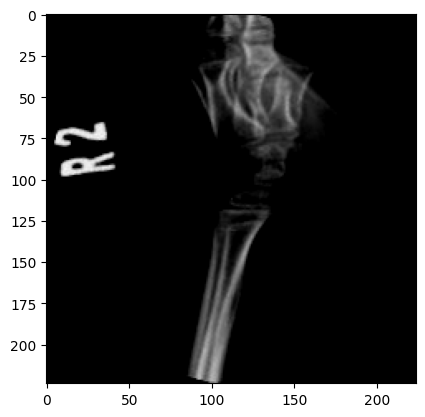

In [ ]:
X, y = next(iter(train_dataloader))
plt.imshow(X[4].permute(1,2,0))

**Mobile Net**

In [ ]:
def makeTheNet(k = 3, s = 1, p = 2):
     class CnnNet(nn.Module):
         def __init__(self):
             super().__init__()

             imgSize = IMAGE_SIZE

             self.conv1 = nn.Conv2d(3, 128, k, s, p)
             self.bnorm1 = nn.BatchNorm2d(128)

             imgSize = ((imgSize - k + 2*p) // s) + 1
             imgSize = imgSize // k

             self.conv2 = nn.Conv2d(128, 256, k, s, p)
             self.bnorm2 = nn.BatchNorm2d(256)

             imgSize = ((imgSize - k + 2*p) // s) + 1
             imgSize = imgSize // k
             self.conv3 = nn.Conv2d(256, 256, k, s, p)
             self.bnorm3 = nn.BatchNorm2d(256)

             imgSize = ((imgSize - k + 2*p) // s) + 1
             imgSize = imgSize // k

             self.fc1 = nn.Linear(imgSize * imgSize * 256, 256)
             self.fc2 = nn.Linear(256, 256)
             self.fc3 = nn.Linear(256, 256)
             self.fc4 = nn.Linear(256, 256)
             self.output = nn.Linear(256, 1)

         def forward(self, x):
             x = F.max_pool2d( self.conv1(x), k)
             x = F.leaky_relu( self.bnorm1(x) )

             x = F.max_pool2d( self.conv2(x), k)
             x = F.leaky_relu( self.bnorm2(x) )

             x = F.max_pool2d( self.conv3(x), k)
             x = F.leaky_relu( self.bnorm3(x) )

             nUnits = x.shape.numel()/x.shape[0]
             x = x.view(-1,int(nUnits))

             x = F.leaky_relu( self.fc1(x) )
             x = F.dropout2d(x, .5)

             x = F.leaky_relu( self.fc2(x) )
             x = F.dropout2d(x, .5)

             x = F.leaky_relu( self.fc3(x) )
             x = F.dropout2d(x, .5)

             x = F.leaky_relu( self.fc4(x) )
             x = F.dropout2d(x, .5)

             return self.output(x)

     net = torchvision.models.mobilenet_v3_large(weights = 'DEFAULT')

     for p in net.parameters():
       p.requires_grad = False

     net.classifier[3] = nn.Linear(1280,1)

     lossfun = nn.BCEWithLogitsLoss()

     optimizer = torch.optim.Adam(net.parameters(), lr = .001)

     return net, lossfun, optimizer

In [ ]:
net, lossfun, optimizer = makeTheNet()
net.to(device)
X, y = X.to(device), y.to(device, dtype = torch.float)
yHat = net(X)
yHat = yHat.squeeze()
lossfun(yHat, y)

tensor(0.6838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

**Training the Network**

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def function2TrainModel():
    epochs = 30  # Adjust epochs as needed

    net, lossfun, optimizer = makeTheNet()  # Assume this is a predefined function that sets up the model
    net.to(device)

    trainAcc = []
    devAcc = []
    trainLoss = []
    devLoss = []

    best_acc = 0  # Initialize best accuracy
    best_model = None  # To store the best model

    for epochi in tqdm(range(epochs)):

        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device, dtype=torch.float)
            yHat = net(X)
            yHat = yHat.squeeze()
            yHat, y = yHat.cpu(), y.cpu()
            loss = lossfun(yHat, y)
            batchAcc.append(torch.mean(((yHat > .0) == y).float()) * 100)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        trainAcc.append(np.mean(batchAcc))
        trainLoss.append(np.mean(batchLoss))

        net.eval()
        with torch.no_grad():
            batchLoss = []
            batchAcc = []

            for X, y in dev_dataloader:
                X, y = X.to(device), y.to(device, dtype=torch.float)
                yHat = net(X)
                yHat = yHat.squeeze()
                yHat, y = yHat.cpu(), y.cpu()
                loss = lossfun(yHat, y)

                batchAcc.append(torch.mean(((yHat > .0) == y).float()) * 100)
                batchLoss.append(loss.item())

            devAcc.append(np.mean(batchAcc))
            devLoss.append(np.mean(batchLoss))

            # Check if current epoch's accuracy is the best
            if devAcc[-1] > best_acc:
                best_acc = devAcc[-1]
                best_model = net.state_dict()  # Save the best model state

    # Optionally, load the best model state back into the model
    net.load_state_dict(best_model)

    return trainAcc, devAcc, trainLoss, devLoss, net

# Ensure to define or import all required elements such as device, train_dataloader, dev_dataloader before calling the function.

In [ ]:
import random

# Setting seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()  # Ensure reproducibility

In [ ]:
trainAcc, devAcc, trainLoss, devLoss, net = function2TrainModel()
path = '/content/drive/MyDrive/model.pth'
torch.save(net.state_dict(), path)

100%|██████████| 30/30 [1:09:13<00:00, 138.44s/it]


In [ ]:
print(max(trainAcc))
print(max(devAcc))

90.06271
85.79882


**Plotting the Accuracy / Loss Curves**

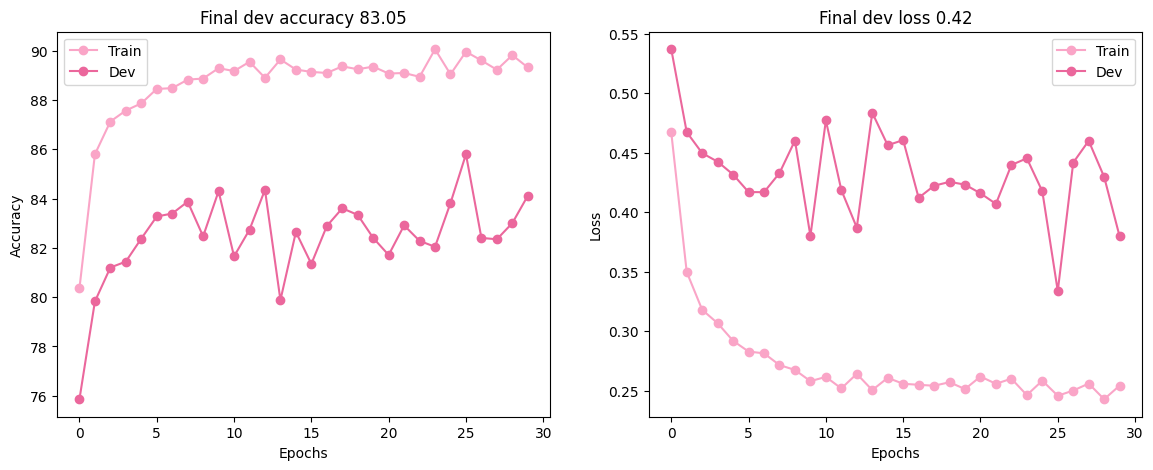

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(trainAcc, 'o-', label='Train')
ax[0].plot(devAcc, 'o-', label='Dev')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Final dev accuracy {np.mean(devAcc[-10:]):.2f}')

ax[1].plot(trainLoss, 'o-', label='Train')
ax[1].plot(devLoss, 'o-', label='Dev')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title(f'Final dev loss {np.mean(devLoss[-10:]):.2f}')

plt.show()

In [ ]:
net.eval()

images = []
yTrue, yPred = [], []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device, dtype=torch.float)
        yHat = net(X)
        yHat = yHat.squeeze()
        yHat, y = yHat.cpu(), y.cpu()

        images.extend(X)
        yTrue.extend(y)
        yPred.extend((yHat > .0).float())

In [ ]:
yTrue, yPred = [yItem.item() for yItem in yTrue], [yItem.item() for yItem in yPred]

**Comparision of Actual vs Predicted**

In [ ]:
def showComparision(images, yTrue, yPred):
    cols = 3
    rows = int(len(images) / cols)

    fig, ax = plt.subplots(rows, cols, figsize = (50, 200))
    fig.subplots_adjust(hspace=.5, wspace=.2)  # Adjust spacing between subplots

    for idx, image in enumerate(images):
        yActual = int(yTrue[idx])
        yPredicted = int(yPred[idx])

        yActualStr = test_dataset.classes[yActual]
        yPredictedStr = test_dataset.classes[yPredicted]

        correctPrediction = (yActual == yPredicted)
        color = 'green' if correctPrediction else 'red'

        i = int(idx / cols)
        j = int(idx % cols)

        # Normalize pixel values to range [0, 1]
        image = image.cpu().view(-1, imgSize, imgSize).permute(1, 2, 0)
        image = image.numpy()  # Convert tensor to NumPy array
        image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize

        # Add padding to the image
        pad = 0.1
        ax[i][j].imshow(image, aspect='auto')
        ax[i][j].set_title(f'Actual: {yActualStr} | Predicted: {yPredictedStr}', fontsize = 40, color = color, y = 1.05)
        ax[i][j].axis('off')

        border = Rectangle((0, 0), image.shape[1]-1, image.shape[0]-1, linewidth=5, edgecolor=color, facecolor='none')
        ax[i][j].add_patch(border)

In [ ]:
visualizableCount = 33
visualizableImages = images[:visualizableCount]
visualizableYTrue = yTrue[:visualizableCount]
visualizableYPred = yPred[:visualizableCount]
showComparision(visualizableImages, visualizableYTrue, visualizableYPred)

**Visualising the Confusion Matrix**

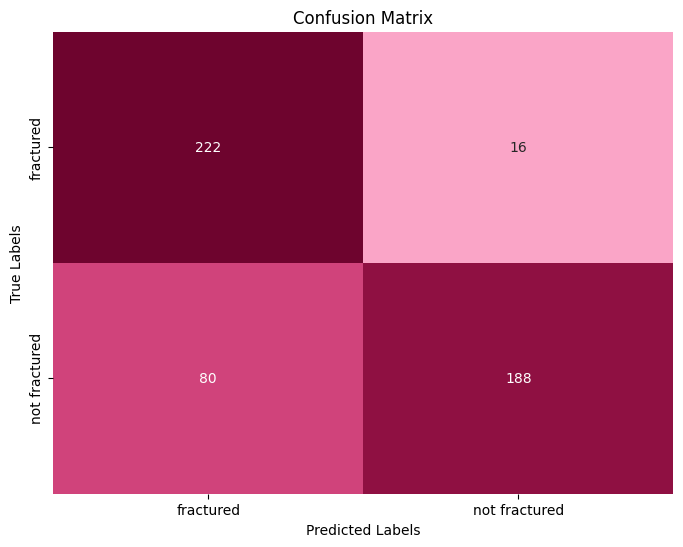

In [ ]:
cm = confusion_matrix(yTrue, yPred)
class_names = test_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Evualuating the Network**

In [ ]:
precision = precision_score(yTrue, yPred)
recall = recall_score(yTrue, yPred)
f1Score = f1_score(yTrue, yPred)

In [ ]:
from sklearn.metrics import classification_report
class_names = class_names  # Example class names

print(classification_report(yTrue, yPred, target_names=class_names))

               precision    recall  f1-score   support

    fractured       0.74      0.93      0.82       238
not fractured       0.92      0.70      0.80       268

     accuracy                           0.81       506
    macro avg       0.83      0.82      0.81       506
 weighted avg       0.83      0.81      0.81       506

